# Recurrent Residual Convolutional Neural Network

### Simon Laurent Lebailly, 2549365, s9sileba@teams.uni-saarland.de
### Christian Mathieu Schmidt, 2537621, s9cmscmi@teams.uni-saarland.de

## 1) Preliminaries

#### Import libaries

In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

#### Use CUDA if possible

In [2]:
#Check if CUDA is available, if not use the CPU.
train_on_GPU = torch.cuda.is_available()
device = torch.device('cuda' if train_on_GPU else 'cpu')

if train_on_GPU:
    print('CUDA available!')
else:
    print('CUDA not available!')

CUDA available!


#### Define Hyperparameters

In [3]:
train = True
validate = True
evaluate = True

batch_size = 8
epochs = 10

learning_rate = 0.00001

## 2) Data

#### Import dataset Cityscapes

In [4]:
import torchvision
from torchvision import transforms
from torchvision import datasets
from torch.utils import data


#Define normalization for dataset
normalize = transforms.Normalize(
    mean = [0.485, 0.456, 0.406],
    std = [0.229, 0.224, 0.225]
)

#Define transformation for train, validation and test dataset
transform = transforms.Compose([
    transforms.Resize((256,512)),
    transforms.ToTensor(),
    normalize
])

class TransformToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        sample_out = (sample*256).long()
        return sample_out

target_transform = transforms.Compose([
    transforms.Resize((256,512)),
    transforms.ToTensor(),
    TransformToTensor()
])


#Path of dataset
root_path = 'C:/Users/chris/Documents/Cityscapes_dataset/Cityscapes'


#Import dataset for training
train_set = datasets.Cityscapes(root=root_path, split='train', mode='fine', target_type='semantic', transform=transform, target_transform=target_transform)
quantity_train = len(train_set)
print('Quantity training data: '+ str(quantity_train))

#Prepare training dataset for NN
train_loader = data.DataLoader(train_set, batch_size=batch_size, shuffle=True)


#Import dataset for validation
validation_set = datasets.Cityscapes(root=root_path, split='val', mode='fine', target_type='semantic', transform=transform, target_transform=target_transform)
quantity_validation = len(validation_set)
print('Quantity validation data: '+ str(quantity_validation))

#Prepare validation dataset for NN
validation_loader = data.DataLoader(validation_set, batch_size=batch_size, shuffle=False)


#Import dataset for testing
test_set = datasets.Cityscapes(root=root_path, split='test', mode='fine', target_type='semantic', transform=transform, target_transform=target_transform)
quantity_test = len(test_set)
print('Quantity testing data: '+ str(quantity_test))

#Prepare test dataset for NN
test_loader = data.DataLoader(test_set, batch_size=batch_size, shuffle=False)


Quantity training data: 2975
Quantity validation data: 500
Quantity testing data: 1525


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([[[ 3,  3,  4,  ...,  3,  3,  3],
         [ 3, 10, 17,  ...,  9,  7,  3],
         [ 3, 13, 23,  ..., 11,  9,  3],
         ...,
         [ 3,  6,  8,  ...,  7,  6,  3],
         [ 3,  5,  7,  ...,  6,  5,  3],
         [ 3,  3,  3,  ...,  3,  3,  3]]])


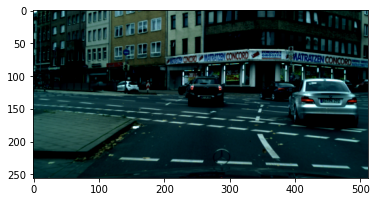

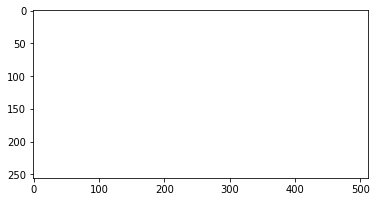

In [5]:
#Printouts for testing train set

#print(train_loader)
#print(validation_loader)
#print(test_loader)

#Tensor to image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

img, segm = train_set[3]
#print(img)
print(segm)
#segm_norm = segm
#segm_norm = (torch.round(segm*256)-1).long()
#print(segm_norm.size())
#targ_min = 32
#targ_max = 0
#for b in range(0, 1):
#    for r in range(0,256):
#        for c in range(0,512):
#            #if label_mask[b][r][c] >= 32:
#                #print("First eval: " + str(label_mask[b][r][c]) + ", " + str(b) + ", " + str(r) + ", " + str(c))
#            if segm_norm[b][r][c] > targ_max:
#                targ_max = segm_norm[b][r][c]
#            if segm_norm[b][r][c] < targ_min:
#                targ_min = segm_norm[b][r][c]
#print("targ_min: " + str(targ_min))
#print("targ_max: " + str(targ_max))

#segm_norm = (segm*8)/256
#print(segm_norm)
#print(img.size())
imshow(torchvision.utils.make_grid(img))
imshow(torchvision.utils.make_grid(segm))
#print(segm)
#segm.show()
#print(type(train_set))
#print(train_set)

## 3) Model

#### Define R2U-Net model

In [6]:
import torch.nn as nn

class R2U_Net(nn.Module):
    def __init__(self):
        super(R2U_Net, self).__init__()
        #define the layers for your model

        #VGG16 as encoder
        self.encode_features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),

            nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            #nn.BatchNorm2d(128),

            nn.Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),

            nn.Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),

            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            #nn.BatchNorm2d(512),
            #nn.Flatten(start_dim=3),
        )

        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(7, 7))

        self.classifier = nn.Sequential(
            nn.Linear(in_features=25088, out_features=4096, bias=True),
            nn.ReLU(),
            nn.Dropout(p=0.5, inplace=False),

            nn.Linear(in_features=4096, out_features=4096, bias=True),
            nn.ReLU(),
            nn.Dropout(p=0.5, inplace=False),

            nn.Linear(in_features=4096, out_features=1000, bias=True),
        )

        #Blabla as decoder
        self.decode_features = nn.Sequential(
            nn.Upsample(size=(8,16)),
            nn.ConvTranspose2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            nn.ConvTranspose2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            nn.ConvTranspose2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            nn.ConvTranspose2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            nn.ConvTranspose2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            #nn.BatchNorm2d(512),
            nn.Upsample(scale_factor=(2.0, 2.0)),
            nn.ConvTranspose2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),

            nn.ConvTranspose2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            nn.Upsample(scale_factor=(2.0, 2.0)),
            nn.ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),

            nn.ConvTranspose2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            nn.Upsample(scale_factor=(2.0, 2.0)),
            nn.ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            nn.Upsample(scale_factor=(2.0, 2.0)),
            nn.ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),

            #nn.BatchNorm2d(32),
            nn.Upsample(scale_factor=(2.0, 2.0)),
            nn.ConvTranspose2d(32, 34, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            #nn.ReLU(),

            nn.Softmax(),
        )



    def encode(self, x):
        out = self.encode_features(x)
        #print(out.size())
        out = self.avgpool(out)
        #print(out.size())
        #out = out.view(-1, 512*7*7)
        #print(out.size())
        #out = self.classifier(out)
        #print(out.size())
        return out


    def decode(self,x):
        #out = x
        out = self.avgpool(x)
        out = self.decode_features(out)
        #print(out.size())
        return out


    def forward(self, x):
        #print(x.size())
        out = self.decode(self.encode(x))
        #print(out.size())
        return out

#### Build R2U-Net model

In [7]:
#Load model to device
r2u_net = R2U_Net().to(device)
print(r2u_net)

R2U_Net(
  (encode_features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU()
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d(256, 512, kernel_size=(3, 3), stride=

## 4) Loss and Optimizer

In [8]:
# loss function
criterion = nn.CrossEntropyLoss().to(device)

# optimizer variable
optimizer = torch.optim.Adam(r2u_net.parameters(), lr=learning_rate)

## 5) Train model

#### Definition train and validation loop

In [9]:
scaler = torch.cuda.amp.GradScaler()


def train_model(epoch, train_loader):
    trainloader_loop = tqdm(train_loader)
    printrate = int(quantity_train/(batch_size*10))
    train_loss = 0.0

    #Set model mode to train
    r2u_net.train()

    #Iterate over all batches in train_loader
    for i, batch in enumerate(trainloader_loop):
        #Input Image for forward pass
        input_image = batch[0].to(device)

        #Label "image" for comparing with loss function
        label_mask = batch[1].to(device)
        label_mask = label_mask.squeeze(1)

        #Forward propagation
        with torch.cuda.amp.autocast():
            output_model = r2u_net(input_image)

            loss = criterion(output_model, label_mask)

            #Print with loss
            train_loss += loss.item()
            if i % printrate == 0:
                print('[%d, %5d] train_loss: %.3f' % (epoch+1, i+1, loss.item()))
                running_loss = 0.0

        #Backward propagation
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        #update tqdm
        trainloader_loop.set_postfix(loss=loss.item())
        val_loss = loss

    print("Finished training!")

    #Calculate validation_loss
    train_loss = train_loss/(quantity_train * batch_size)
    
    return train_loss



def validate_model(epoch, validation_loader):
    validationloader_loop = tqdm(validation_loader)
    printrate = int(quantity_validation/(batch_size*10))
    validation_loss = 0.0

    #Set model mode to evaluation
    r2u_net.eval()

    #Iterate over all batches in validation_loader
    for i, batch in enumerate(validationloader_loop):
        #Input Image for forward pass
        input_image = batch[0].to(device)

        #Label "image" for comparing with loss function
        label_mask = batch[1].to(device)
        label_mask = label_mask.squeeze(1)

        #Forward propagation
        with torch.cuda.amp.autocast():
            output_model = r2u_net(input_image)

            loss = criterion(output_model, label_mask)

            #Print with loss
            validation_loss += loss.item()
            if i % printrate == 0:
                print('[%d, %5d] validation_loss: %.3f' % (epoch+1, i+1, loss.item()))
                running_loss = 0.0

        #update tqdm
        validationloader_loop.set_postfix(loss=loss.item())

    print("Finished validation!")
    
    #Calculate validation_loss
    validation_loss = validation_loss/(quantity_validation * batch_size)
    
    return validation_loss


#### Training and validation of the model

In [10]:
import torch.optim.lr_scheduler as lr_scheduler

#Configure scheduler for learning_rate
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=int(2 * (epochs/10)))

#Load parameters
if os.path.isfile('task_2_model_parameters.pt'):
    r2u_net = torch.load('task_2_model_parameters.pt')

#Statistical parameters
train_loss = 0.0
train_loss_history = []
validation_loss = 0.0
validation_loss_history = []
learning_rate_history = []


#Iterate over every epoch
if train:
    for epoch in range(epochs):
        #Train model
        train_loss = train_model(epoch, train_loader)
        train_loss_history.append(train_loss)

        #Validate model
        if validate:
            validation_loss = validate_model(epoch, validation_loader)
            validation_loss_history.append(validation_loss)

        #Learning rate history
        learning_rate_history.append(learning_rate)

        scheduler.step(validation_loss)
        torch.save(r2u_net, 'task_2_model_parameters.pt')

    print("Finished train model!")


#### Print lists of mean losses and scheduled learning for every epoch

In [11]:
print("Train loss of every epoch: " + str(train_loss_history))
print("Validation loss of every epoch: " + str(validation_loss_history))
print("Learning rate of every epoch: " + str(learning_rate_history))

Train loss of every epoch: []
Validation loss of every epoch: []
Learning rate of every epoch: []


## 6) Evaluation

#### Evaluation metrics

In [12]:
from scipy import spatial
import sklearn.metrics as metrics


def one_row(ground_truth, prediction):
    truth = prediction.argmax(dim=1).view(1,-1)
    truth = np.squeeze(truth.numpy())

    pred = ground_truth.view(1,-1)
    pred = np.squeeze(pred.numpy())

    return truth.astype(float), pred.astype(float)


def evaluate(ground_truth, predictions):
    ground_truth2 = ground_truth.copy()
    predictions2 = predictions.copy()

    f1_score = 0
    auc_score = 0
    dice_coefficient = 0

    listlen = min(len(ground_truth2),len(predictions2))

    for l in range(0, listlen):
        x = ground_truth2[l]
        y = predictions2[l]

        transform_tensors = one_row(x, y)

        f1_score += metrics.f1_score(transform_tensors[0], transform_tensors[1],average=None)
        auc_score += metrics.roc_auc_score(transform_tensors[0], transform_tensors[1], average=None, multi_class='ovo')
        dice_coefficient += abs(spatial.distance.dice(transform_tensors[0], transform_tensors[1], w=None))

    f1_score = f1_score/listlen
    auc_score = auc_score/listlen
    dice_coefficient = dice_coefficient/listlen

    return f1_score, auc_score, dice_coefficient

#### Evaluation

In [13]:
f1_score = -1000.0
auc_score = -1000.0
dice_coefficient = -1000.0

truth_list = []
pred_list = []

In [14]:
#Only during the programming. We dont want want to build the testlist every time
breaker = True

if evaluate:
    testloader_loop = tqdm(test_loader)

    #Set model mode to evaluation
    r2u_net.eval()

    #Iterate over all batches in validation_loader
    for i, batch in enumerate(testloader_loop):
        if breaker and i > 2:
            break
        #Input Image for forward pass
        test_image = batch[0].to(device)

        #Label "image" for comparing with loss function
        ground_truth = batch[1].cpu()
        ground_truth = ground_truth.squeeze(1)

        #Forward propagation
        with torch.cuda.amp.autocast():
            prediction = r2u_net(test_image)

        truth_list.append(ground_truth.float())
        pred_list.append(prediction.cpu().float())

    scores = evaluate(truth_list, pred_list)

    f1_score = scores[0]
    auc_score = scores[1]
    dice_coefficient = scores[2]

    print("Finished evaluation!")

  0%|          | 0/382 [00:00<?, ?it/s]c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\torch\nn\modules\container.py:119: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
  1%|          | 3/382 [00:02<04:21,  1.45it/s]


AxisError: axis 1 is out of bounds for array of dimension 1

#### Print lists of scores

In [ ]:
print("F1 score: " + str(f1_score))
print("AUC score: " + str(auc_score))
print("DICE coefficient: " + str(dice_coefficient))

#### Evaluation plots